(1180, 1452, 3)


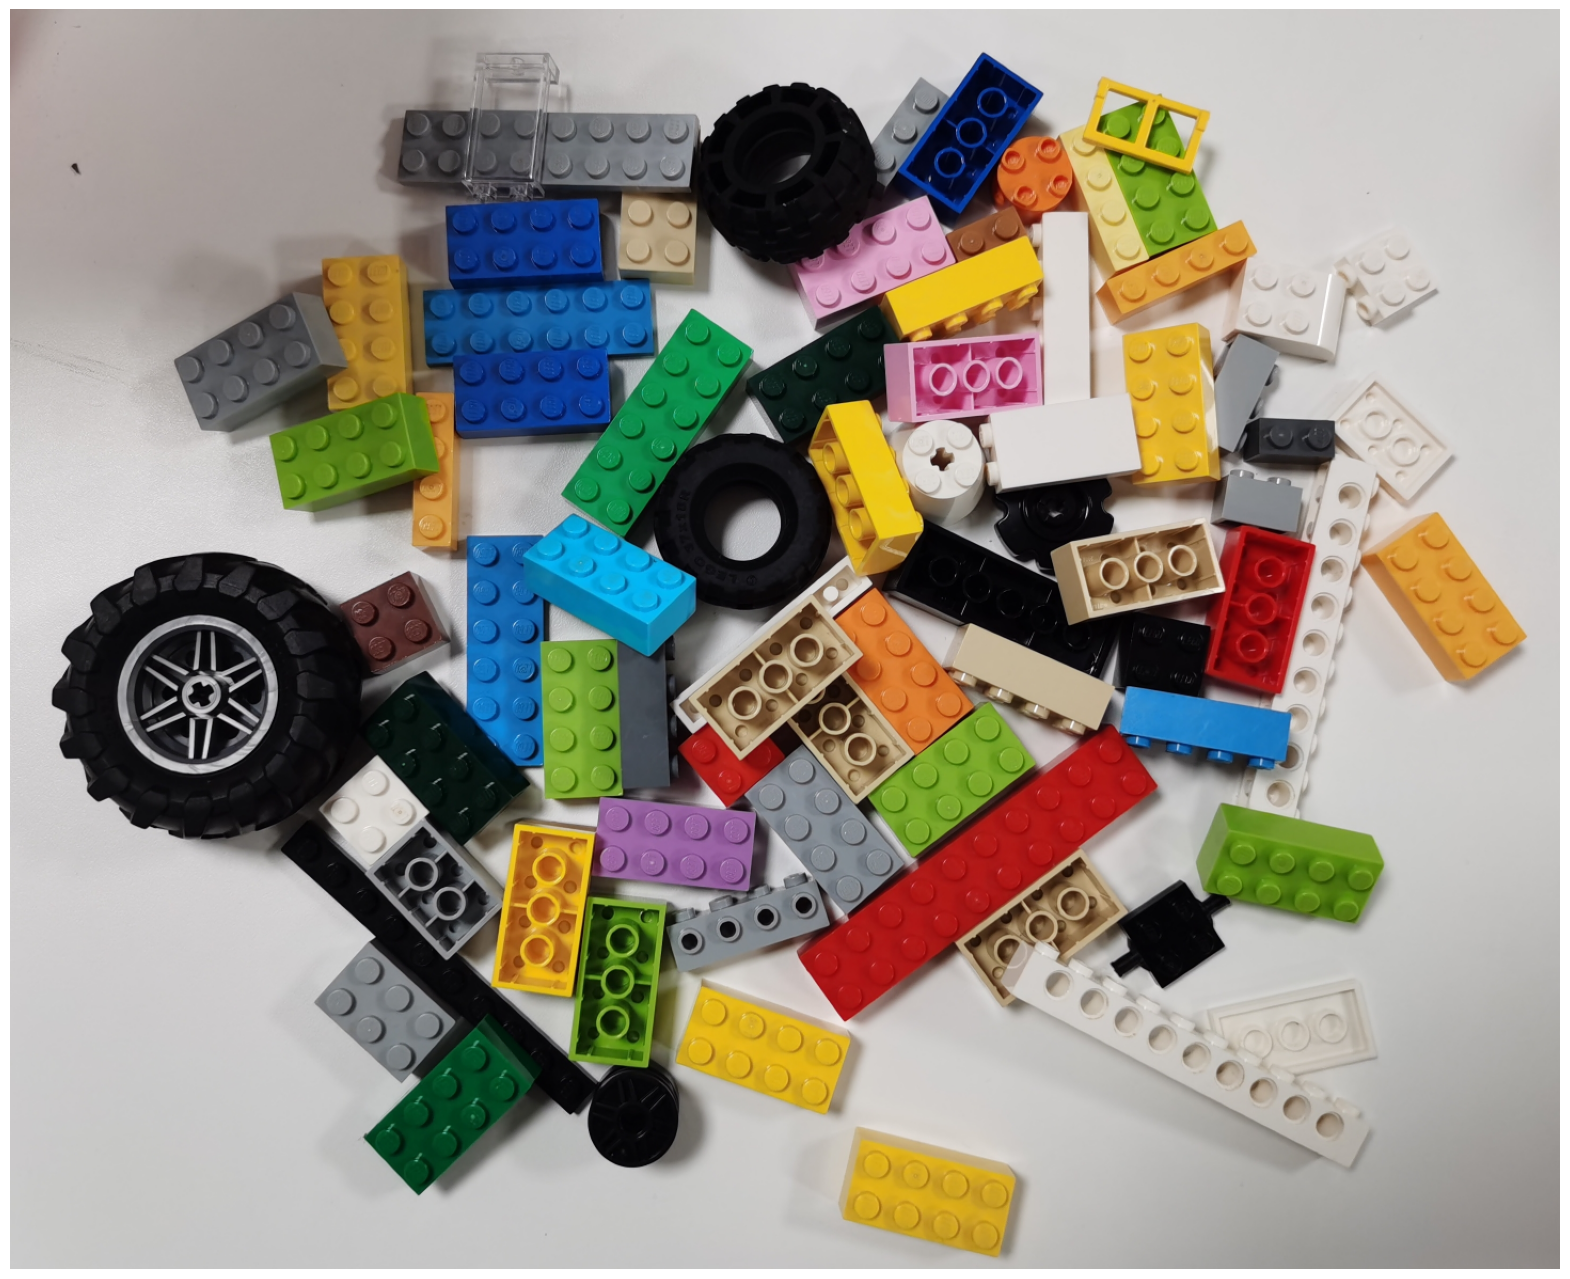

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

#定义一个函数，输入两个二维numpy二值数组，对两张图片的每个相同位置像素做异或操作，返回异或后的图片，并统计异或后的图片中1的个数
def xor(img1,img2):
    img1 = img1.astype(np.bool)
    img2 = img2.astype(np.bool)
    out = np.logical_xor(img1,img2)
    out = out.astype(np.uint8)
    count = np.sum(out)
    return count

def cosine_similarity(image1, image2):
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()
    return np.dot(image1_flat, image2_flat) / (np.linalg.norm(image1_flat) * np.linalg.norm(image2_flat))

# 示例
# similarity = cosine_similarity(image1, image2)
def jaccard_similarity(image1, image2):
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    return np.sum(intersection) / np.sum(union)

# 示例
# similarity = jaccard_similarity(image1, image2)    

def show_anns(anns):#显示标注
    count = 0
    img_gorup = []#用于存储符合要求的mask[i]['segmentation']
    area_group = []#用于存储符合要求的mask[i]['area']
    
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)#按照面积排序
    ax = plt.gca()#获取当前的坐标轴
    # print(ax)
    ax.set_autoscale_on(False)#关闭自动缩放
    
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))#创建一个全为1的图片
    #为什么会有四个通道：因为后面要将mask的区域设置为随机颜色，所以需要四个通道，第四个通道设置为0，表示透明度为0
    img[:,:,3] = 0#将第四个通道设置为0
    #检查anns中的每个标注cosine_similarity高的标注
    
    for ann in sorted_anns:#遍历标注
        #如果area小于1000则跳过
        if ann['area'] < 8000:###!!!!!!!!!
            continue
        m = ann['segmentation']#获取标注的mask        
        color_mask = np.concatenate([np.random.random(3), [0.35]])#随机生成一个颜色
        # #选取一个m中为True的点标注星
        # points = np.argwhere(m)#获取m中为True的点的坐标
        # #在图中标出：
        # ax.scatter(points[:, 1], points[:, 0], color=color_mask, marker='.', s=1, edgecolor='white', linewidth=1.25)
        img[m] = color_mask#将mask的区域设置为随机颜色
        count += 1
        img_gorup.append(m)
        area_group.append(ann['area'])
    #弹出img_gorup和area_group中的第一个元素,因为第一个元素是最大的背景
    img_gorup.pop(0)
    area_group.pop(0)    
        
    print(count)
    ax.imshow(img)
    return img_gorup,area_group#用这个过滤掉不符合要求的mask[i]['segmentation']


# image = cv2.imread('images/2.jpg')
image = cv2.imread('images/10.jpg')
image = cv2.resize(image,None,fx=0.5,fy=0.5)#缩小图片
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #转为二值图
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# #二值化
# ret, image = cv2.threshold(image, 160, 255, cv2.THRESH_BINARY)
#显示图片大小
print(image.shape)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()


In [2]:
def plot_similarity_heatmap(images,image_areas):
    n = len(images)
    similarity_matrix = np.zeros((n, n))
    low_similarity_count = 0
    # 计算每对图像之间的相似度
    for i in range(n):
        for j in range(n):
            similarity = cosine_similarity(images[i], images[j])
            similarity_matrix[i, j] = similarity
            # # 统计余弦相似度小于 0.5 的图像对
            # if i != j and similarity < 0.5:
            #     low_similarity_count += 1
    #统计余弦相似度小于 0.2 的图像对
    for i in range(n):
        #j从i+1开始，因为相似度矩阵是对称的
        for j in range(i+1,n):
            #一旦大于0.2，就从images中删除,并修改n
            if similarity_matrix[i, j] > 1e-6:
                images.pop(j)
                image_areas.pop(j)
                n -= 1
                break
    
    # 绘制热力图
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Cosine Similarity Heatmap")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()
    
    return n,image_areas,images#images用于创建新的融合图像

In [3]:
#仿照上面的余弦相似度计算，计算jaccard相似度用于过滤掉不符合要求的mask[i]['segmentation']
def plot_similarity_heatmap_jaccard(images,image_areas):
    n = len(images)
    similarity_matrix = np.zeros((n, n))
    low_similarity_count = 0
    # 计算每对图像之间的相似度
    for i in range(n):
        for j in range(n):
            similarity = jaccard_similarity(images[i], images[j])
            similarity_matrix[i, j] = similarity
            # # 统计余弦相似度小于 0.5 的图像对
            # if i != j and similarity < 0.5:
            #     low_similarity_count += 1
    #统计余弦相似度小于 0.2 的图像对
    for i in range(n):
        #j从i+1开始，因为相似度矩阵是对称的
        for j in range(i+1,n):
            #一旦大于0.2，就从images中删除,并修改n
            if similarity_matrix[i, j] > 1e-5:
                images.pop(j)
                image_areas.pop(j)
                n -= 1
                break
    
    # 绘制热力图
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Jaccard Similarity Heatmap")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()
    
    return n,image_areas,images#images用于创建新的融合图像

In [4]:
#利用hash值过滤掉不符合要求的mask[i]['segmentation']
#定义感知哈希算法,输入为两张numpy二值数组，输出为两张图片的哈希值
#注意img1和img2是两个numpy二值数组,不需要使用cv的全部操作
def pHash(img1,img2):
    #数据类型转换
    # print(img1.dtype)
    img1 = img1.astype(np.uint8)*255
    img2 = img2.astype(np.uint8)*255
    
    #绘制图片
    # plt.figure(figsize=(20,20))
    # plt.subplot(121)
    # plt.imshow(img1)
    # plt.subplot(122)
    # plt.imshow(img2)
    # plt.show()
     
    #缩放为32*32
    img1 = cv2.resize(img1,(32,32))
    img2 = cv2.resize(img2,(32,32))
    #转换为灰度图
    # img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    # img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    #转换为浮点型
    img1 = np.float32(img1)
    img2 = np.float32(img2)
    #离散余弦变换
    img1 = cv2.dct(img1)
    img2 = cv2.dct(img2)
    #取左上角的8*8，这些代表图片的最低频率
    #这个操作等价于c++中利用opencv实现的掩码操作
    #在python中进行掩码操作，可以直接这样取出图像矩阵的某一部分
    img1 = img1[0:8,0:8]
    img2 = img2[0:8,0:8]
    #计算均值
    img1_mean = cv2.mean(img1)[0]
    img2_mean = cv2.mean(img2)[0]
    #大于均值为1，小于均值为0
    img1 = (img1 >= img1_mean)*1
    img2 = (img2 >= img2_mean)*1
    # #计算哈希值
    # hash1 = 0
    # hash2 = 0
    # for i in range(8):
    #     hash1 += img1[i]*(2**(8-i))
    #     hash2 += img2[i]*(2**(8-i))  
        # 大于均值为1，小于均值为0
    # img1 = (img1 >= img1_mean) * 1
    # img2 = (img2 >= img2_mean) * 1

    # 计算哈希值
    hash1 = ''.join(str(bit) for bit in img1.flatten())
    hash2 = ''.join(str(bit) for bit in img2.flatten())

    # 计算汉明距离
    hamming_distance = sum(ch1 != ch2 for ch1, ch2 in zip(hash1, hash2))
    
    return hash1,hash2,hamming_distance
    


In [5]:
#利用hash值过滤掉不符合要求的mask[i]['segmentation']
#输入一个图片列表images和其中的area列表，绘制哈希值热力图，过滤掉相互汉明距离小于5的图片，返回过滤后的图片列表
def plot_hash_heatmap(images,image_areas):
    n = len(images)
    hash_matrix = np.zeros((n, n))
    # 计算每对图像之间的汉明距离
    for i in range(n):
        for j in range(n):
            hash1,hash2,hamming_distance = pHash(images[i],images[j])
            hash_matrix[i, j] = hamming_distance
            # # 统计汉明距离小于 5 的图像对
            # if i != j and hamming_distance < 5:
            #     low_similarity_count += 1
    #统计汉明距离小于 5 的图像对
    for i in range(n):
        #j从i+1开始，因为相似度矩阵是对称的
        for j in range(i+1,n):
            if hash_matrix[i, j] < 8:
                images.pop(j)
                image_areas.pop(j)
                n -= 1
                break
    
    # 绘制热力图
    plt.figure(figsize=(8, 6))
    plt.imshow(hash_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title("Hash Heatmap")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()
    
    return n,image_areas,images#images用于创建新的融合图像

In [6]:
#创建一个函数接受一个二值图片组segmentations的list，融合其中的图片为一张图片,可以不融合融合会干扰
def merge_images(segmentations):
    #获取图片的大小
    h, w = segmentations[0].shape
    #创建一张全为0的图片
    merged_image = np.zeros((h, w))
    
    #绘制segmentations[0]的mask
    # img = np.ones((segmentations[0].shape[0], segmentations[0].shape[1], 4))
    # img[:,:,3] = 0
    # img[segmentations[0]] = [0,0,0,1]
    # plt.figure(figsize=(20,20))
    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()
    #遍历segmentations并把其中每一张图片的mask保存9mask文件夹中
    
    # for i in range(len(segmentations)):
    # #保存到mask文件夹中
    #     #暂存图片
    #     temp = segmentations[i].copy()
    #     #转换类型为uint8
    #     temp = temp*255
    #     temp = temp.astype(np.uint8)
    #     #保存
    #     cv2.imwrite('mask/'+str(i)+'.png',temp)

    #遍历segmentations
    for segmentation in segmentations:
        #将segmentation中为True的点设置为黑色，背景为白色
        # merged_image[segmentation] = 1
        merged_image[segmentation] = 255
        
    return merged_image

In [7]:
#绘制areas的分布图
def plot_areas(areas):
    plt.figure(figsize=(8, 6))
    plt.hist(areas, bins=100)
    plt.title("Areas Distribution")
    plt.xlabel("Area")
    plt.ylabel("Count")
    plt.show()
    
#将areas中的每个元素规整到到最近的10000的倍数，首先将areas中的每个元素除以10000，大于0.5的向上取整，小于0.5的向下取整，然后再乘以10000
def regularize_areas(areas):
    areas = np.array(areas) / 10000
    areas = np.where(areas > 0.5, np.ceil(areas), np.floor(areas))
    areas = areas * 10000
    return areas
   


In [8]:
#定义一个基于样本求k个高斯分布均值的函数，在样本长度中等分k个点，然后取这k个点的样本值作为k个高斯分布的均值
def findmeas(data,k):
    #获取样本长度
    n = len(data)
    #等分k个点
    index = np.linspace(0,n-1,k+1)
    #取这k个点的样本值作为k个高斯分布的均值
    print(index)
    means = []
    for i in range(k):
        means.append(data[int(index[i])])
    return means

In [9]:
#假设面积分布符合k个高斯分布，使用EM算法估计k个高斯分布的参数，输入为areas，和k，输出为k个高斯分布的参数
def estimate_gaussian_parameters(areas, k):
    #初始化均值和方差
    #统计areas中的最大值和最小值然后均分成k份，作为每个高斯分布的均值，标准差初始化为1
    #把areas标准化到0-1之间
    
    areas = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))
    #求样本标准差
    std = np.std(areas)
    labels = np.zeros(len(areas))
    
    
    # means = np.linspace(np.min(areas), np.max(areas), k)
    
    #初始化每个高斯分布的均值
    means = findmeas(areas,k)
    # print(means)
    # #基于先验的映射
    # means = mapping_areas()
    # print(means)
    # print(means)
    #高斯分布的标准差初始化为样本标准差
    stds = np.ones(k) * std
    # 压缩标准差为之前的1/100
    stds = stds
    #初始化每个样本的标签，初始化到最近的高斯分布
    for i in range(len(areas)):
        labels[i] = np.argmin(np.abs(areas[i] - means))
    
    # #初始化每个高斯分布的权重，按照每个高斯分布的样本数占总样本数的比例
    # weights = np.zeros(k)
    # for i in range(k):
    #     weights[i] = np.sum(labels == i) / len(areas)
    # print(weights)
    # #把权重的顺序取反
    # weights = weights[::-1]
    # print(weights)
    weights = np.ones(k) / k
   
    #初始化每个样本的概率，这个概率是每个样本属于每个高斯分布的概率
    #概率设置为距离最近高斯分布为1，其他为0
    probs = np.zeros((len(areas), k))
    # for i in range(len(areas)):
    #     probs[i, int(labels[i])] = 1    
   
    # EM算法
    # 迭代次数
    max_iter = 2
    # for _ in range(max_iter):
    #     #E步：计算每个样本属于每个高斯分布的概率
    #     for i in range(len(areas)):
    #         for j in range(k):
    #             probs[i, j] = weights[j] * np.exp(-0.5 * (areas[i] - means[j]) ** 2 / stds[j] ** 2) / (np.sqrt(2 * np.pi) * stds[j])
    #         probs[i] /= np.sum(probs[i])
    #     #M步：更新每个高斯分布的参数
    #     for j in range(k):
    #         weights[j] = np.sum(probs[:, j]) / len(areas)
    #         means[j] = np.sum(probs[:, j] * areas) / np.sum(probs[:, j])
    #         stds[j] = np.sqrt(np.sum(probs[:, j] * (areas - means[j]) ** 2) / np.sum(probs[:, j]))
    #         #压缩标准差为之前的1/100
    #         # stds[j] = stds[j] / 100
           
    #     #计算每个样本的标签
    #     for i in range(len(areas)):
    #         labels[i] = np.argmax(probs[i])
            
     #基于数据优化能检查偏离值的EM算法，要求两个检查：1.检查每个样本属于每个高斯分布的概率是否大于0.8，一旦大于0.8则将其标签设置为该高斯分布的标签，并且不再使用EM算法更新该样本的标签；2.检查每个高斯分布中包含的所有样本属于该该高斯分布的概率是否大于0.5,如果存在不是则不再使用EM算法更新该高斯分布的参数，保存该高斯分布的参数不变
    #检查每个样本属于每个高斯分布的概率是否大于0.8，一旦大于0.8则将其标签设置为该高斯分布的标签，并且不再使用EM算法更新该样本的标签
     #新的EM算法
    for _ in range(max_iter):
        
        #E步：计算每个样本属于每个高斯分布的概率
        for i in range(len(areas)):
            for j in range(k):
                if stds[j] == 0:
                    probs[i, j] = weights[j] * np.exp(-0.5 * (areas[i] - means[j]) ** 2 / 1e-6)
                else:
                    probs[i, j] = weights[j] * np.exp(-0.5 * (areas[i] - means[j]) ** 2 / stds[j] ** 2) 
        if np.sum(probs[i]) != 0:        
            probs[i] /= np.sum(probs[i])
            
        #检查每个样本属于每个高斯分布的概率是否大于0.8，一旦大于0.8则将其标签设置为该高斯分布的标签，并且不再使用EM算法更新该样本的标签
        for i in range(len(areas)):
            for j in range(k):
                if probs[i, j] > 0.9:
                    labels[i] = j
                    probs[i] = 0
                    probs[i, j] = 1
                    break  
        
                
        # M步：更新每个高斯分布的参数
        for j in range(k):
            weights[j] = np.sum(probs[:, j]) / len(areas)
            if np.sum(probs[:, j]) != 0:
                means[j] = np.sum(probs[:, j] * areas) / np.sum(probs[:, j])
            else:
                means[j] = 0
            if np.sum(probs[:, j]) != 0:
                stds[j] = np.sqrt(np.sum(probs[:, j] * (areas - means[j]) ** 2) / np.sum(probs[:, j]))
            else:
                stds[j] = 0
        
        #打印迭代次数和方差数组
        print(f"iter: {_}, stds: {stds}")
        
        # M步：更新每个高斯分布的参数
        # for j in range(k):
        #     #检查每个高斯分布中包含的所有样本属于该该高斯分布的概率是否大于0.5,如果存在不是则不再使用EM算法更新该高斯分布的参数，保存该高斯分布的参数不变
        #     for i in range(len(areas)):
        #       if labels[i] == j and probs[i, j] < 0.9:
        #           break#这个break打断的是for j in range(k)这个循环
        #     else:
        #         weights[j] = np.sum(probs[:, j]) / len(areas)
        #         means[j] = np.sum(probs[:, j] * areas) / np.sum(probs[:, j])
        #         stds[j] = np.sqrt(np.sum(probs[:, j] * (areas - means[j]) ** 2) / np.sum(probs[:, j]))
                                 
        #计算每个样本的标签
        for i in range(len(areas)):
            labels[i] = np.argmax(probs[i])
            
            
            
    #打印每个高斯分布的参数
    for i in range(k):
        print(f"Mean: {means[i]:.2f}, Std: {stds[i]:.2f}, Weight: {weights[i]:.2f}")
    return means, stds, weights, labels, probs



#绘制k个高斯分布的函数,用光滑的曲线表示
def plot_gaussian_distributions(areas, means, stds, weights, labels, probs):
    # plt.figure(figsize=(8, 6))
    #对areas进行标准化
    areas = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))
    print(stds)
    # print(means)
    #先绘制原始的分布并且把高度调整到1
    # plt.hist(areas, bins=100, density=True)#bins表示直方图的柱数
    print(weights)
    #绘制k个高斯分布
    #随机生成自变量
    x = np.linspace(np.min(areas), np.max(areas), 100)
    #绘制k个高斯分布
    for i in range(len(means)):
        #如果标准差为0则只绘制一根高度为weights[i]的直线
        if stds[i] <1e-3:
            plt.hlines(weights[i], np.min(areas), np.max(areas), colors = "c", linestyles = "dashed", label=f"Gaussian {i+1}")
            # continue
        else:
            y = weights[i] * np.exp(-0.5 * (x - means[i]) ** 2 / stds[i] ** 2) 
            plt.plot(x, y, label=f"Gaussian {i+1}")
            #用直线标出每个高斯分布的均值
            plt.vlines(means[i], 0, np.max(y), colors = "c", linestyles = "dashed")
            
        
    plt.legend()
    plt.title("Areas Distribution")
    plt.xlabel("Area")
    plt.ylabel("Probability Density")
    plt.show()
    
    

#把样本area按照高斯分布的标签分成k组,每个样本归入置信度最高的高斯分布，打印高斯分布的样本个数
def group_areas(areas, labels, k):
    groups = [[] for _ in range(k)]
    for i in range(len(areas)):
        groups[int(labels[i])].append(areas[i])
    for i in range(k):
        print(f"Group {i + 1} has {len(groups[i])} samples")
    return groups

In [10]:
#基于先验的映射：指定k个类别的面积分布数组归一化到0-1之间做求k个高斯分布的均值
def mapping_areas():
    #定义面积分布数组
    areas = [2,3,4,6,8,10,12,20]
    #归一化到0-1之间,并且转为numpy数组
    areas = np.array(areas) / 20
    #求k个高斯分布的均值
    return areas

In [11]:
#根据原始分布聚类
def classify_areas(areas, k):
    #areas归一化到0-1之间
    areas = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))
    #用mappping_areas()求k个高斯分布的均值
    means = mapping_areas()
    #初始化labels
    labels = np.zeros(len(areas))
    for i in range(len(areas)):
        labels[i] = np.argmin(np.abs(areas[i] - means))
   
    #打印每一类的个数  
    for i in range(k):
        print(f"Group {i + 1} has {np.sum(labels == i)} samples")  
        

In [12]:
#写一个KMeans函数,输入为areas和k，输出为k个分类的areas并且打印每个分类的个数
from sklearn.cluster import KMeans
def k_means_clustering(areas, k):
    
    #areas归一化到0-1之间，并保存映射关系
    # mean = np.min(areas)
    # min_area = np.min(areas)
    # max_area = np.max(areas)
    # areas = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))

    # 将数据重塑以适应 KMeans
    data = np.array(areas).reshape(-1, 1)
    
    #用mappping_areas()根据先验求k个均值
    # means = mapping_areas()
    
    #把means作为初始的聚类中心
    # kmeans = KMeans(n_clusters=k, init=means.reshape(-1, 1),n_init=1,max_iter=10).fit(data)
    # 应用 KMeans 算法
    # kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    #调整迭代次数
    # kmeans = KMeans(n_clusters=k, random_state=0, max_iter=3).fit(data)
    #调整迭代次数和容忍度
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=5000, tol=1e-7).fit(data)
    #修改算法的参数为elkan
    # kmeans = KMeans(n_clusters=k, random_state=0, max_iter=5000, tol=1e-7, algorithm='elkan').fit(data)

    # 获取每个数据点的聚类标签
    labels = kmeans.labels_

    # 将数据点组织到聚类中
    clusters = [[] for _ in range(k)]
    for label, area in zip(labels, areas):
        clusters[label].append(area)
    
     # 根据它们的平均值对聚类进行排序
    clusters.sort(key=lambda x: np.mean(x))
       
    # 打印每个聚类中的项目数
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i+1}: {len(cluster)} items")
        
    # # #映射回原始的面积分布
    # for i in range(k):
    #     for j in range(len(clusters[i])):
    #         clusters[i][j] = clusters[i][j] * (max_area - min_area) + min_area
    #         #取整
    #         clusters[i][j] = np.round(clusters[i][j])

    return clusters
    
    


In [13]:
#定义一个函数检查prob[k]中是否一个为1其余为0，是则返回True，否则返回False
def check_prob(prob):
    print(prob)
    for i in range(len(prob)):
        if prob[i] == 1:
            return True
    return False

In [14]:
# 定义模板匹配函数，输入为一张图片和一个模板，两个都是二值图，在图片中寻找模板，并在图片中标出模板的位置（有可能有多个）,使用cv2.matchTemplate函数
def template_match(image, template):
    # #获取模板的长宽
    h, w = template.shape
    #使用cv2.matchTemplate函数
    res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    #设置阈值
    threshold = 0.9
    #获取匹配程度大于阈值的点的坐标
    # loc = np.argwhere(res >= threshold)
    loc = np.where(res >= threshold)
    new_image = image.copy()
    #在原图中标出匹配的位置
    for pt in zip(*loc):
        cv2.rectangle(new_image, pt, (pt[0] + w, pt[1] + h), 255, 2)
    #绘制
    plt.subplot(121)
    plt.imshow(template, cmap='gray')
    plt.title('template')
    plt.subplot(122)
    plt.imshow(image, cmap='gray')
    plt.title('matched result')
    plt.show()    
    
    #统计匹配的个数
    count = len(loc)
    print(count)
    return image


In [15]:
# #读取模板
# template = cv2.imread('images/tem1.png')
# print(template.shape)
# #转为二值图
# template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
# print(template.shape)
# #显示
# plt.figure(figsize=(20,20))
# plt.imshow(template)
# plt.axis('off')
# plt.show()

In [16]:
#自动生成mask
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# sam_checkpoint = "sam_vit_b_01ec64.pth" 
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

#设置为GPU为3号
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#自动生成采样点对图像进行分割
mask_generator = SamAutomaticMaskGenerator(sam)

#掩码生成器参数修改
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=20,#控制采样点的间隔，值越小，采样点越密集
    pred_iou_thresh=0.86,#mask的iou阈值
    stability_score_thresh=0.96,#mask的稳定性阈值
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=50,  #最小mask面积，会使用opencv滤除掉小面积的区域
)

# masks = mask_generator.generate(image)
masks = mask_generator_2.generate(image)
print(image.shape)

# print(len(masks))

# # 遍历打印masks中每一个元素的area
# for i in range(len(masks)):
#     print(masks[i]['area'])

plt.figure(figsize=(16,16))
plt.imshow(image)
# show_heatmap(masks)   
imgs,areas=show_anns(masks)#显示mask
plt.axis('on')

#取imgs中的第一个元素和第二个元素计算hash值
# img1_hash,img2_hash,hdit = pHash(imgs[2],imgs[3])#0，1，9，10相似
# print(img1_hash)
# print(img2_hash)
# print(hdit)

#过滤以前的mask[i]['segmentation']融合图
new_image = merge_images(imgs)
#使用逻辑运算交换黑白
new_image = np.logical_not(new_image)
new_image = new_image*255
new_image = new_image.astype(np.uint8)
plt.show() 
#显示融合后的图片
plt.figure(figsize=(16,16))
plt.imshow(new_image)
plt.axis('on')
plt.show()

#余弦相似性过滤掉不符合要求的mask[i]['segmentation']
# num,areas1,images=plot_similarity_heatmap(imgs,areas)#显示imgs这个list中的每一个元素的相似度热力图
#利用jaccard相似度过滤掉不符合要求的mask[i]['segmentation']
# num,areas1,images=plot_similarity_heatmap_jaccard(imgs,areas)#显示imgs这个list中的每一个元素的相似度热力图

#利用hash算法过滤掉不符合要求的mask[i]['segmentation']
num,areas1,images=plot_hash_heatmap(imgs,areas)#显示imgs这个list中的每一个元素的相似度热力图
print(num)

#过滤以后的图片
new_image = merge_images(images)
#使用逻辑运算交换黑白
new_image = np.logical_not(new_image)
new_image = new_image*255
new_image = new_image.astype(np.uint8)
plt.show() 
#显示融合后的图片
plt.figure(figsize=(16,16))
plt.imshow(new_image)
plt.axis('on')
plt.show()


# # 基于面积的数量估计
plot_areas(areas1)#显示areas的分布图

# #直接使用areas1进行聚类
# classify_areas(areas1,8)

#采用kmeans聚类
# KMeans_areas(areas1,8)
clusters = k_means_clustering(areas1,10)
print(clusters)


# # actual_categories = 0#统计高斯分布统计出的样本个数
# # #利用EM算法估计areas1中的高斯分布的参数
# means, stds, weights, labels, probs = estimate_gaussian_parameters(areas1,8)
# #定义新的areas2,areas3包含labels中的不为0的元素
# #绘制k个高斯分布的函数
# plot_gaussian_distributions(areas1, means, stds, weights, labels, probs)
# #统计每一组的个数
# groups = group_areas(areas1, labels, 8)
# print(groups)


# #基于几何形状的数量估计，采用模板匹配的方法
# #读取模板
# template = cv2.imread('images/tem1.png')
# template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
# print(template.shape)
# #进行模板匹配
# matched_image = template_match(new_image, template)
#显示匹配后的图片
# plt.figure(figsize=(16,16))
# plt.imshow(matched_image)
# plt.axis('on')
# plt.show()



# # #规则化areas
# areas1 = regularize_areas(areas1)
# print(len(areas1))
# #显示规则化后的areas的分布图
# plot_areas(areas1)




RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.